### Lab 2: HR Diagram of NGC 6819

<!-- Below are the steps to reduce data:
1. Stack bias frames to compute median frame
2. Subtract bias frame from dark frame and stack to compute median frame
3. $\rm~Flat_{\rm~{dome}} = \frac{flat_{\rm~}}{}$ -->

In [426]:
import os 
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from photutils.aperture import CircularAperture
from photutils.background import LocalBackground, MedianBackground
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

import astroalign

#### 1. Data Reduction

In [11]:
# Directory where data is stored
_cache_dir =  "c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\HR_Diagram"

In [12]:
# Load Data 
hdu_lst = np.array([])
for f in os.listdir(_cache_dir):
    hdu_lst = np.append(hdu_lst, fits.open(os.path.join(_cache_dir,f)))

In [13]:
# Keys to sort fits files 
obj_lst = np.array([0]*len(hdu_lst), dtype='object')
for i in range(len(hdu_lst)):
    obj_lst[i] = hdu_lst[i].header['OBJECT']

print('filenames', np.unique(obj_lst))

filenames ['bias AR' 'darks 10 AR' 'dome flats 10 B AR' 'dome flats 10 V AR'
 'landolt B AR 25s' 'landolt V AR 30s' 'ngc 6819 B AR 25s'
 'ngc 6819 v AR 30s']


In [72]:
# Sort frames by label
bias_frames = hdu_lst[np.where(obj_lst=='bias AR')]
dark_frames = hdu_lst[np.where(obj_lst=='darks 10 AR')]

dome_flats_B_frames = hdu_lst[np.where(obj_lst=='dome flats 10 B AR')]
dome_flats_V_frames = hdu_lst[np.where(obj_lst=='dome flats 10 V AR')]

landolt_B_frames = hdu_lst[np.where(obj_lst=='landolt B AR 25s')]
landolt_V_frames = hdu_lst[np.where(obj_lst=='landolt V AR 30s')]

ngc6819_B_frames = hdu_lst[np.where(obj_lst=='ngc 6819 B AR 25s')]
ngc6819_V_frames = hdu_lst[np.where(obj_lst=='ngc 6819 v AR 30s')]

In [331]:
def reduce_data(bias, dark, dome_flat, science):
    """ Performs all data reduction steps and returns reduced science frame
    """

    # Median Bias Frames
    bias_full = np.median(np.stack([b.data for b in bias]),axis=0)
    print(np.median(bias_full))
    # Median Dark Frames 
    dark_exptime = dark[0].header['EXPTIME']
    dark_full = np.median(np.stack([(b.data - bias_full) for b in dark]),axis=0)

    # Median Dome Flats
    df_exptime = dome_flat[0].header['EXPTIME']
    dome_flat_full = np.median(np.stack([( (b.data/df_exptime) \
                                        - (dark_full/dark_exptime) )/np.median(b.data) for b in dome_flat]), axis=0)

    # Median Science Frames
    sci_exptime = science[0].header['EXPTIME']
    sci_full = np.median(np.stack([((b.data/sci_exptime) - (dark_full/dark_exptime))/dome_flat_full for b in science]), axis=0)

    print(f"Exposure Times:\nDome Flat - {df_exptime}s\nDark - {dark_exptime}s\nScience - {sci_exptime}s\n")
    return sci_full
    

In [332]:
# Reduce science frames
red_sci_ngc6819_B = reduce_data(bias_frames, dark_frames, dome_flats_B_frames, ngc6819_B_frames)
red_sci_ngc6819_V = reduce_data(bias_frames, dark_frames, dome_flats_V_frames, ngc6819_V_frames)

red_sci_landolt_B = reduce_data(bias_frames, dark_frames, dome_flats_B_frames, landolt_B_frames)
red_sci_landolt_V = reduce_data(bias_frames, dark_frames, dome_flats_V_frames, landolt_V_frames)

sci_red = {'ngc6819_B':red_sci_ngc6819_B,'ngc6819_V':red_sci_ngc6819_V, 'landolt_B':red_sci_landolt_B, 
                'landolt_V':red_sci_landolt_V}


1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 25s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 30s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 25s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 30s



In [330]:
fits.writeto(os.path.join(_cache_dir, "ngc6819_B.fits"), sci_red['ngc6819_B'])
fits.writeto(os.path.join(_cache_dir,"ngc6819_V.fits" ), sci_red['ngc6819_V'])

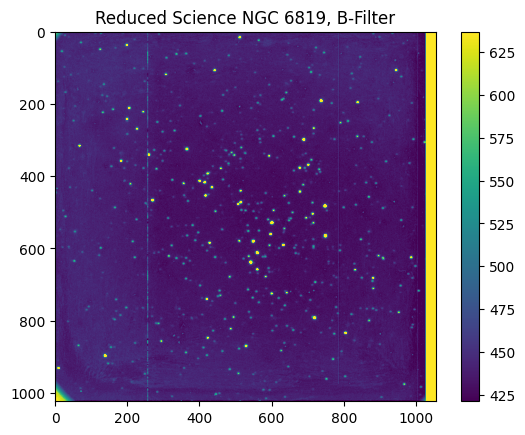

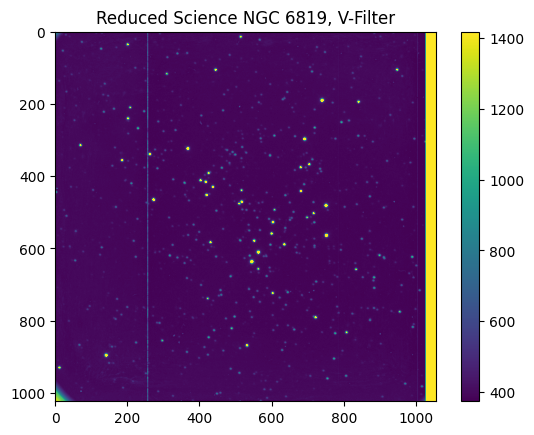

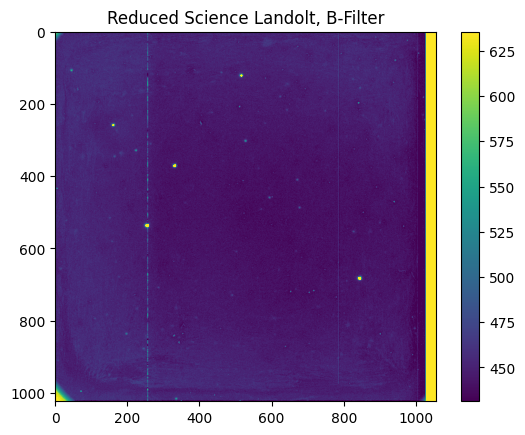

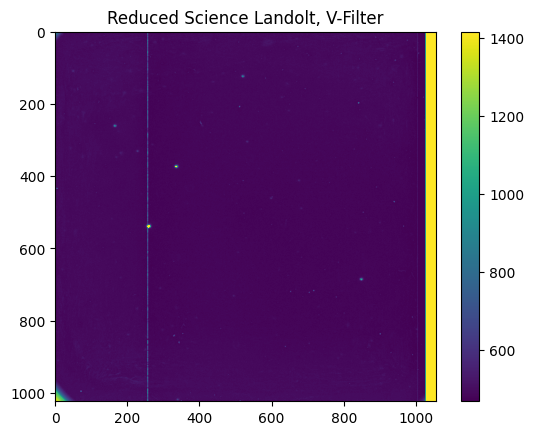

In [333]:
plt.figure()
plt.title("Reduced Science NGC 6819, B-Filter")
plt.imshow(red_sci_ngc6819_B, vmin=np.percentile(red_sci_ngc6819_B, 3), vmax=np.percentile(red_sci_ngc6819_B, 97))
plt.colorbar()

plt.figure()
plt.title("Reduced Science NGC 6819, V-Filter")
plt.imshow(red_sci_ngc6819_V, vmin=np.percentile(red_sci_ngc6819_V, 3), vmax=np.percentile(red_sci_ngc6819_V, 97))
plt.colorbar()

plt.figure()
plt.title("Reduced Science Landolt, B-Filter")
plt.imshow(red_sci_landolt_B, vmin=np.percentile(red_sci_landolt_B, 3), vmax=np.percentile(red_sci_landolt_B, 97))
plt.colorbar()

plt.figure()
plt.title("Reduced Science Landolt, V-Filter")
plt.imshow(red_sci_landolt_V, vmin=np.percentile(red_sci_landolt_V, 3), vmax=np.percentile(red_sci_landolt_V, 97))
plt.colorbar()

#### 2. Aperture Photometry using  `Photutils`

Landolt Field Stars: [https://www.wiyn.org/Observe/Landolt/recommendedfields.html](https://www.wiyn.org/Observe/Landolt/recommendedfields.html)

Find stars in field using `DAOStarFinder`

In [456]:
res_B = sci_red['ngc6819_B'][100:700, 257:760] # [250:700, 300:750]
res_V = sci_red['ngc6819_V'][100:700, 257:760]

# Astrometric alignment of both images
res_B_reg = astroalign.register(res_B,res_V,max_control_points=50)

In [457]:
_, median_B, std_B = sigma_clipped_stats(res_B_reg[0], sigma=5.0)   
#print(f"mean:{mean}, median:{median}, std:{std}") 
daofind = DAOStarFinder(fwhm=5.0, threshold=3.*std_B, exclude_border=True)  
sourcesB = daofind(res_B_reg[0] - median_B)  

In [458]:
sourcesB_df = sourcesB.to_pandas()
positionsB = sourcesB_df.filter(['xcentroid', 'ycentroid'])

In [462]:
sourcesB_df

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,285.619580,4.586181,0.372254,-0.006905,0.273064,49,0.0,10.303841,1.017216,-0.018533
1,2,131.243359,5.336489,0.728414,0.774363,-0.743396,49,0.0,38.590562,2.813972,-1.123299
2,3,374.390784,5.412078,0.632575,-0.698644,-0.159012,49,0.0,51.974218,4.604073,-1.657855
3,4,314.352763,5.912458,0.463985,-0.818130,-0.289179,49,0.0,12.988996,1.034776,-0.037116
4,5,186.614756,6.747137,0.405797,-0.137852,-0.514605,49,0.0,575.065718,49.856301,-4.244300
...,...,...,...,...,...,...,...,...,...,...,...
360,361,119.580366,588.342293,0.510013,-0.300936,-0.691111,49,0.0,48.453846,3.933361,-1.486910
361,362,151.823802,590.726646,0.203705,-0.214054,-0.270979,49,0.0,10.517867,1.093943,-0.097487
362,363,464.716935,592.853455,0.390862,-0.152610,-0.488296,49,0.0,198.585596,18.373447,-3.160477
363,364,408.399149,594.163532,0.587320,-0.300406,-0.264847,49,0.0,4.749863,1.001054,-0.001144


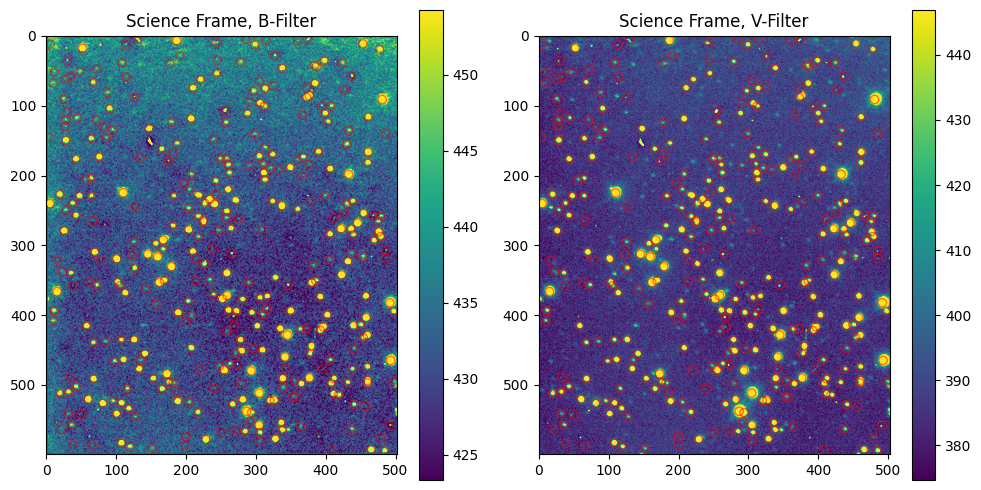

In [467]:
# positions = np.transpose((sources_df['xcentroid'], sources_df['ycentroid']))
aperturesB = CircularAperture(positionsB, r=6)
# aperturesV = CircularAperture(positionsV, r=6)

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title("Science Frame, B-Filter")
im1 = ax[0].imshow(res_B_reg[0],vmin=np.percentile(res_B_reg[0], 3), vmax=np.percentile(res_B_reg[0], 97))
plt.colorbar(im1)

ax[1].set_title("Science Frame, V-Filter")
im2 = ax[1].imshow(res_V,vmin=np.percentile(res_V, 3), vmax=np.percentile(res_V, 97))
plt.colorbar(im2)

aperturesB.plot(ax=ax[0], color='red', lw=1, alpha=0.5);
aperturesB.plot(ax=ax[1], color='red', lw=1, alpha=0.5);
plt.tight_layout()

In [451]:
def aperture_photometry(data, x, y, r_star, r_in, r_out, verbose=False):
    """ Performs aperture photometry on point source 
    """
    # Determine local background and subtract it 
    locback = LocalBackground(r_in, r_out, bkg_estimator=MedianBackground())
    loc_bkg = locback(data,x,y)

    print(f"Local Background: {round(loc_bkg,3)}") if verbose else None

    # Create circular aperture
    aper = CircularAperture([x, y], r=r_star)
    res = aper.do_photometry(data-loc_bkg)

    return res

def star_magnitude(m_ref, F_1, F_ref):
    return -2.5*np.log10(F_1 / F_ref) + m_ref

In [452]:
# Landolt Field Star 111 1965 reference flux and magnitude
F_ref_B = aperture_photometry(sci_red['landolt_B'], 332.352205, 372.104596, 10, 12, 15, verbose=True)[0][0] # 2,4,6
F_ref_V = aperture_photometry(sci_red['landolt_V'], 332.352205, 372.104596, 10, 12, 15, verbose=True)[0][0]
m_ref_B = 1.710 + 11.419
m_ref_V = 11.419	

Local Background: 442.431
Local Background: 483.405


In [465]:
F_ref_B, F_ref_V

(27187.770489133985, 45885.36719402258)

In [463]:
star_fluxes_B = [aperture_photometry(res_B, x, y, 10, 12, 15, verbose=False)[0][0] for x,y in positionsB.values]
mag_B = (star_fluxes_B - F_ref_B) + m_ref_B

star_fluxes_V = [aperture_photometry(res_V, x, y, 10, 12, 15, verbose=False)[0][0] for x,y in positionsB.values]
mag_V = (star_fluxes_V - F_ref_V) + m_ref_V

#star_mags_B = np.array([star_magnitude(m_ref_B, F, F_ref_B) for F in star_fluxes_B])
# star_fluxes_V = [aperture_photometry(res_V, x, y, 10, 12, 15, verbose=False)[0][0] for x,y in positionsB.values]
#star_mags_V = np.array([star_magnitude(m_ref_V, F, F_ref_V) for F in star_fluxes_V])

Text(0, 0.5, 'V')

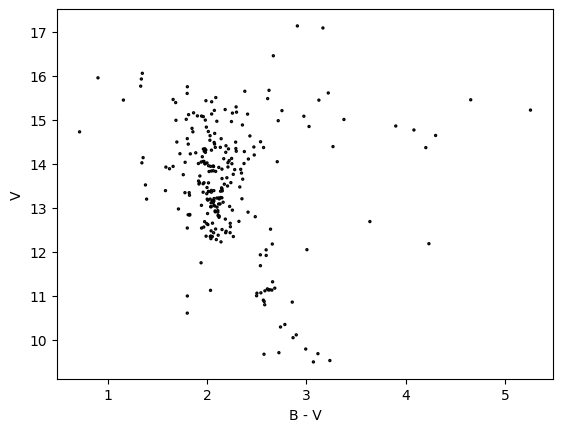

In [455]:
plt.figure()
plt.scatter(star_mags_B- star_mags_V, star_mags_V,s=2, c='None', edgecolors='k')
plt.xlabel("B - V")
plt.ylabel("V")